In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [132]:
#valores iniciais
p = 1/3
GS_L, GD_L = p*5, (1-p)*5    #nS
G_Na, G_K, G_Ca, G_KCa = p*3, p*2, (1-p)*2, (1-p)*2.5   #uS
G_KAHP, G_c = (1-p)*40, 20  #nS
E_Na, E_K, E_Ca, E_L = 60, -75, 80, -60 #mV
CS, CD = p*100, (1-p)*100   #pF
tca = 50    #ms
k = (2.5 * 10**6) / (1-p)   #M/C

In [133]:
#variaveis de gating
def m_inf(Vs):
    return alpha_m(Vs) / (alpha_m(Vs) + beta_m(Vs))

def h_inf(Vs):
    return alpha_h(Vs) / (alpha_h(Vs) + beta_h(Vs))

def n_inf(Vs):
    return alpha_n(Vs) / (alpha_n(Vs) + beta_n(Vs))

def mCa(Vd):
    return alpha_mca(Vd) / (alpha_mca(Vd) + beta_mca(Vd))

def mKCa(Vd):
    return alpha_mkca(Vd) / (alpha_mkca(Vd) + beta_mkca(Vd))

def mKAHP(Vd):
    return alpha_mkahp(Vd) / (alpha_mkahp(Vd) + beta_mkahp(Vd))

def chi(Ca):
    return min(4000*Ca, 1)

def t_m(Vs):
    return 1 / (alpha_m(Vs) + beta_m(Vs))

def t_h(Vs):
    return 1 / (alpha_h(Vs) + beta_h(Vs))

def t_n(Vs):
    return 1 / (alpha_n(Vs) + beta_n(Vs))

def t_mca(Vd):
    return 1 / (alpha_mca(Vd) + beta_mca(Vd))

def t_mkca(Vd):
    return 1 / (alpha_mkca(Vd) + beta_mkca(Vd))

def t_mkahp(Vd):
    return 1 / (alpha_mkahp(Vd) + beta_mkahp(Vd))

def alpha_m(Vs):
    if Vs == -0.0469:
        return 320000 / 250*np.exp(-250*(Vs+0.0469))
    else:
        return (320 * 10**3 * (Vs + 0.0469)) / (1 - np.exp(-250*(Vs+0.0469)))

def alpha_h(Vs):
    return 128*np.exp(-55.556*(Vs+0.043))

def alpha_n(Vs):
    if Vs == -0.0249:
        return 16000 / 200*np.exp(-200*(Vs+0.0249))
    else:
        return (16 * 10**3 * (Vs+0.0249)) / (1 - np.exp(-200*(Vs+0.0249)))
def alpha_mca(Vd):
    return 1600 / (1+np.exp(-72*(Vd-0.005)))

def alpha_mkca(Vd):
    if Vd >= -0.010:
        return 2000*np.exp(-37.037*(Vd+0.0535))
    elif Vd <= -0.010:
        return np.exp( (Vd+0.050)/0.011 - (Vd+0.0535)/0.027 ) / 0.018975

def alpha_mkahp(Ca):
    return min(20, 20000*Ca)

def beta_m(Vs):
    if Vs == -0.0199:
        return 280000 / 200 * np.exp(200*(Vs+0.0199))
    else:
        return 280 * 10**3 * (Vs+0.0199) / (np.exp(200*(Vs+0.0199)) - 1)

def beta_h(Vs):
    return 4000 / (1 + np.exp(-200*(Vs+0.020)))

def beta_n(Vs):
    return 250 * np.exp(-25*(Vs+0.040))

def beta_mca(Vd):
    if Vd == -0.0089:
        return 20000 / 200*np.exp(200*(Vd+0.0089))
    else:
        return 2 * 10**4 * (Vd + 0.0089) / (np.exp(200*(Vd+0.0089)) - 1)

def beta_mkca(Vd):
    if Vd>= -0.010:
        return 0
    elif Vd <= -0.010:
        return (2000*np.exp(-(Vd+0.0535)/0.027)) - alpha_mkca(Vd)

def beta_mkahp(Vd):
    return 4


In [134]:
#intervalo de tempo
t = np.arange(0, 30, 0.05)

#corrente dentrito
def ID_inj(t):
    I = 0
    ti = 0
    tf = 30
    return I*(t>ti)-I*(t>tf)

#corrente soma
def IS_inj(t):
    I = 0
    ti = 0
    tf = 30
    return I*(t>ti)-I*(t>tf)

#equacoes do modelo
def dALLdt(X, t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp = X
    dVsdt = (IS_inj(t) - GS_L * (Vs-E_L) - G_Na * m**2 * h*(Vs-E_Na) - G_K * n**2 *(Vs-E_K) + G_c * (Vd-Vs)) / CS
    dVddt = (ID_inj(t) - GD_L*(Vd-E_L) - G_Ca * mca**2 * (Vd-E_Ca) - G_KCa * mkca * chi(Ca) * (Vd-E_K) - G_KAHP * mkahp * (Vd-E_K) + G_c * (Vs-Vd)) / CD
    dCadt = -(Ca/tca) - k*G_Ca * mca**2 * (Vd-E_Ca)
    dmdt = (m_inf(Vs) - m) / t_m(Vs)
    dhdt = (h_inf(Vs) - h) / t_h(Vs)
    dndt = (n_inf(Vs) - n) / t_n(Vs)
    dmcadt = (mCa(Vd) - mca) / t_mca(Vd)
    dmkcadt = (mKCa(Vd) - mkca) / t_mkca(Vd)
    dmkahpdt = (mKAHP(Vd) - mkahp) / t_mkahp(Vd)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt

In [135]:
#solucoes com valores iniciais
X = odeint(dALLdt, [-60, -60, 0, 0, 0.5, 0.4, 0, 0.2, 0.2], t)
Vs = X[:,0]
Vd = X[:,1]
Ca = X[:,2]
m = X[:,3]
h = X[:,4]
n = X[:,5]
mca = X[:,6]
mkca = X[:,7]
mkahp = X[:,8]

'#solucoes com valores iniciais\nX = odeint(dALLdt, [-60, -60, 0, 0, 0.5, 0.4, 0, 0.2, 0.2], t)\nVs = X[:,0]\nVd = X[:,1]\nCa = X[:,2]\nm = X[:,3]\nh = X[:,4]\nn = X[:,5]\nmca = X[:,6]\nmkca = X[:,7]\nmkahp = X[:,8]'

In [136]:
#vetores para salvar as solucoes
sol_am = []
sol_ah = []
sol_an = []
sol_amkahp = []
sol_amca = []
sol_amkca = []
sol_bmca = []
sol_bmkca = []
sol_bmkahp = []
sol_bm = []
sol_bh = []
sol_bn = []

val_v = []
val_ca = []

for v in range(-85, 50):
    vm = v * 10**-3
    val_v.append(v)

    #soma
    sol_am.append(alpha_m(vm))
    sol_ah.append(alpha_h(vm))
    sol_an.append(alpha_n(vm))
    sol_bm.append(beta_m(vm))
    sol_bh.append(beta_h(vm))
    sol_bn.append(beta_n(vm))

    #dendrito
    sol_amca.append(alpha_mca(vm))
    sol_amkca.append(alpha_mkca(vm))
    sol_bmca.append(beta_mca(vm))
    sol_bmkca.append(beta_mkca(vm))
    sol_bmkahp.append(beta_mkahp(vm))

for c in range(0,3):
    ca = c * 10**-3
    val_ca.append(c)
    sol_amkahp.append(alpha_mkahp(ca))

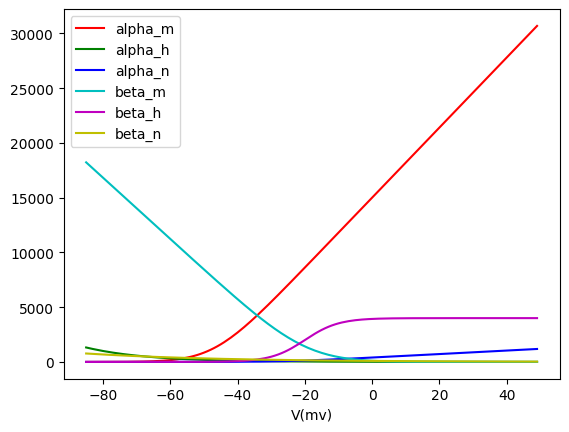

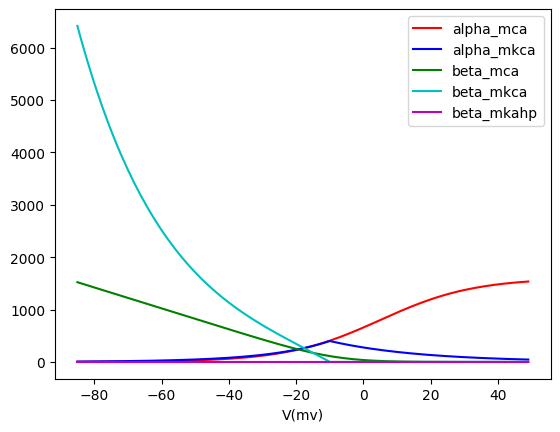

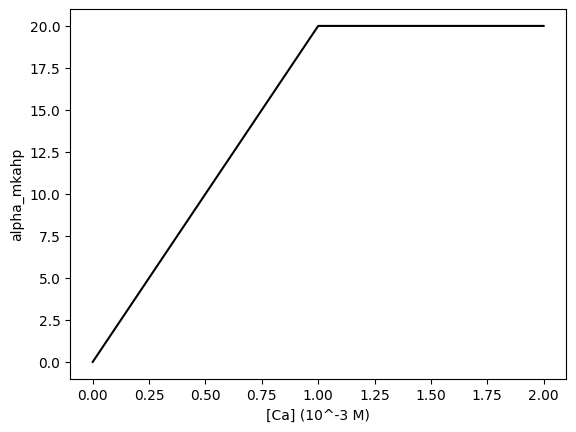

In [137]:
plt.plot(val_v, sol_am, 'r', label='alpha_m')
plt.plot(val_v, sol_ah, 'g', label='alpha_h')
plt.plot(val_v, sol_an, 'b', label='alpha_n')
plt.plot(val_v, sol_bm, 'c', label='beta_m')
plt.plot(val_v, sol_bh, 'm', label='beta_h')
plt.plot(val_v, sol_bn, 'y', label='beta_n')
plt.xlabel('V(mv)')
plt.legend()
plt.show()

plt.plot(val_v, sol_amca, 'r', label='alpha_mca')
plt.plot(val_v, sol_amkca, 'b', label='alpha_mkca')
plt.plot(val_v, sol_bmca, 'g', label='beta_mca')
plt.plot(val_v, sol_bmkca, 'c', label='beta_mkca')
plt.plot(val_v, sol_bmkahp, 'm', label='beta_mkahp')
plt.xlabel('V(mv)')
plt.legend()
plt.show()


plt.plot(val_ca, sol_amkahp, 'k')
plt.ylabel('alpha_mkahp')
plt.xlabel('[Ca] (10^-3 M)')
plt.show()